In [1]:
import warnings
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file

warnings.filterwarnings("ignore")

Setup Complete


In [12]:
league = "spain-laliga"
start_season = 2012
save_pipeline = False
random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

filtered_cols = [
    'home_points_pct', 
    'home_win_pct', 'home_draw_pct', 'home_loss_pct',
    'home_points_pct_last_games',
    # 'home_win_pct_last_games', 'home_draw_pct_last_games', 'home_loss_pct_last_games',
    'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct',
    'home_team_xg', 'home_opp_xg',
    'home_team_score', 'home_opp_score',
    'home_home_team_xg', 'home_home_opp_xg',
    'home_home_team_score', 'home_home_opp_score',
    'away_points_pct', 
    'away_win_pct', 'away_draw_pct', 'away_loss_pct',
    'away_points_pct_last_games',
    # 'away_win_pct_last_games', 'away_draw_pct_last_games', 'away_loss_pct_last_games',
    'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct',
    'away_team_xg', 'away_opp_xg',
    'away_team_score', 'away_opp_score',
    'away_away_opp_xg', 'away_away_team_xg',
    'away_away_opp_score', 'away_away_team_score',
    'home_odds', 'away_odds', 'draw_odds', 
    'home_elo', 'away_elo'
]

filtered_cols=['home_points_pct', 'home_win_pct', 'home_draw_pct', 'home_loss_pct', 'home_points_pct_last_games', 'home_home_win_pct', 'home_home_draw_pct', 'home_home_loss_pct', 'home_team_xg', 'home_opp_xg', 'home_team_score', 'home_opp_score', 'home_home_team_xg', 'home_home_opp_xg', 'home_home_team_score', 'home_home_opp_score', 'away_points_pct', 'away_win_pct', 'away_draw_pct', 'away_loss_pct', 'away_points_pct_last_games', 'away_away_win_pct', 'away_away_draw_pct', 'away_away_loss_pct', 'away_team_xg', 'away_opp_xg', 'away_team_score', 'away_opp_score', 'away_away_opp_xg', 'away_away_team_xg', 'away_away_opp_score', 'away_away_team_score', 'home_odds', 'away_odds', 'draw_odds', 'home_elo', 'away_elo']

filtered_cols.extend([
    "home_ahc_odds",
    "ahc_line",
    "away_ahc_odds",
    "overs_odds",
    "totals_line",
    "unders_odds",
])

markets = {
    "result": [["H", "D", "A"], 2.2],
    "ahc_result": [["H", "A", "P"], 1.6],
    "totals_result": [["O", "U", "P"], 1.6]
}

selected_models = ["random_forest_default", "svm", "gradient_boosting"]
preprocess = False
min_odds = 2.2
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 4940/4940 [00:01<00:00, 4780.48it/s]

Successfully generated teams ELOs.


,season,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,league,...,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds,result,ahc_result,totals_result,home_elo,away_elo
0,2012,2012-08-18,1,Celta Vigo,NaN,0,1,NaN,Málaga,spain-laliga,...,0.25,1.80,2.02,2.50,1.88,A,A,U,1500.00,1500.00
1,2012,2012-08-18,1,Mallorca,NaN,2,1,NaN,Espanyol,spain-laliga,...,0.50,1.82,1.97,2.25,1.93,H,H,O,1500.00,1500.00
2,2012,2012-08-18,1,Sevilla,NaN,2,1,NaN,Getafe,spain-laliga,...,0.75,2.00,2.02,2.50,1.88,H,H,O,1500.00,1500.00
3,2012,2012-08-19,1,Athletic Club,NaN,3,5,NaN,Betis,spain-laliga,...,0.75,1.80,1.97,2.50,1.93,A,A,O,1500.00,1500.00
4,2012,2012-08-19,1,Barcelona,NaN,5,1,NaN,Real Sociedad,spain-laliga,...,2.75,1.95,2.05,3.75,1.85,H,H,O,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2024,2025-05-24,38,Rayo Vallecano,2.2,0,0,0.6,Mallorca,spain-laliga,...,0.75,2.10,1.80,2.00,2.05,D,A,U,1517.41,1490.94
4936,2024,2025-05-24,38,Real Madrid,2.6,2,0,0.8,Real Sociedad,spain-laliga,...,1.25,1.98,1.80,3.00,2.05,H,H,U,1807.22,1526.85
4937,2024,2025-05-25,38,Athletic Club,1.2,0,3,3.5,Barcelona,spain-laliga,...,-0.25,1.98,1.98,3.00,1.88,A,A,P,1689.06,1819.68
4938,2024,2025-05-25,38,Girona,0.0,0,4,2.7,Atlético Madrid,spain-laliga,...,-0.50,1.98,1.98,3.00,1.88,A,A,O,1518.76,1711.87


In [4]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "ahc_result",
        "totals_result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
        "home_ahc_odds",
        "ahc_line",
        "away_ahc_odds",
        "overs_odds",
        "totals_line",
        "unders_odds",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 4940/4940 [02:30<00:00, 32.87it/s] 


In [5]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_score,away_score,home_elo,away_elo,home_ahc_odds,ahc_line,away_ahc_odds,overs_odds,totals_line,unders_odds
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,1,2,1527.22,1451.53,2.15,0.75,1.78,1.97,2.50,1.93
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,0,3,1479.30,1445.86,1.80,0.25,2.10,2.07,2.50,1.82
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,1,2,1534.66,1467.45,1.85,1.00,2.05,2.02,2.75,1.88
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,3,2,1468.69,1475.38,2.07,0.25,1.82,1.82,2.50,2.07
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,5,3,1471.72,1472.98,2.07,0.50,1.82,1.90,2.25,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0,0,1517.41,1490.94,1.78,0.75,2.10,1.80,2.00,2.05
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,2,0,1807.22,1526.85,1.88,1.25,1.98,1.80,3.00,2.05
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0,3,1689.06,1819.68,1.88,-0.25,1.98,1.98,3.00,1.88
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,0,4,1518.76,1711.87,1.88,-0.50,1.98,1.98,3.00,1.88


In [6]:
last_season = matches.iloc[-1]["season"]

# Prepare a list of function calls for each season
function_calls = []

for season in range(start_season + 1, last_season + 1):
    for result_col, market_values in markets.items():
        class_order, _ = market_values

        # Store a tuple with season, result_col, and a lambda function
        function_calls.append((
            season,
            result_col,
            lambda season=season, result_col=result_col, class_order=class_order: pf.simulate_with_classification(
                data_df,
                start_season,
                season,
                filtered_cols,
                random_state=random_state,
                preprocess=preprocess,
                voting_classifier_models=selected_models,
                result_col=result_col,
                class_order=class_order,
            )
        ))

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
last_season_models = {}

# Initialize matches outside the loop
matches = data_df.copy()

for season, result_col, func in tqdm(function_calls):
    season_matches, trained_models = func()
    
    # Update the main matches dataframe with new values
    for col in season_matches.columns:
        # Only update rows that exist in matches
        matches.loc[season_matches.index, col] = season_matches[col]

    if season == last_season:
        last_season_models[result_col] = trained_models

Training and evaluating models throughout the seasons...


100%|██████████| 36/36 [04:09<00:00,  6.93s/it]


In [7]:
matches

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,proba_totals_result_U_ada_boost,proba_totals_result_P_ada_boost,pred_totals_result_mlp,proba_totals_result_O_mlp,proba_totals_result_U_mlp,proba_totals_result_P_mlp,pred_totals_result_voting_classifier,proba_totals_result_O_voting_classifier,proba_totals_result_U_voting_classifier,proba_totals_result_P_voting_classifier
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0.333107,0.336205,O,0.813635,0.044632,0.141733,U,0.402644,0.166922,0.430434
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,0.331410,0.334158,O,0.839533,0.033778,0.126689,O,0.469616,0.135328,0.395056
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0.309391,0.344493,O,0.794969,0.147394,0.057637,U,0.379143,0.068268,0.552589
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,0.332517,0.335450,O,0.700404,0.222494,0.077102,U,0.335326,0.078107,0.586567


Feature Importances for Result:


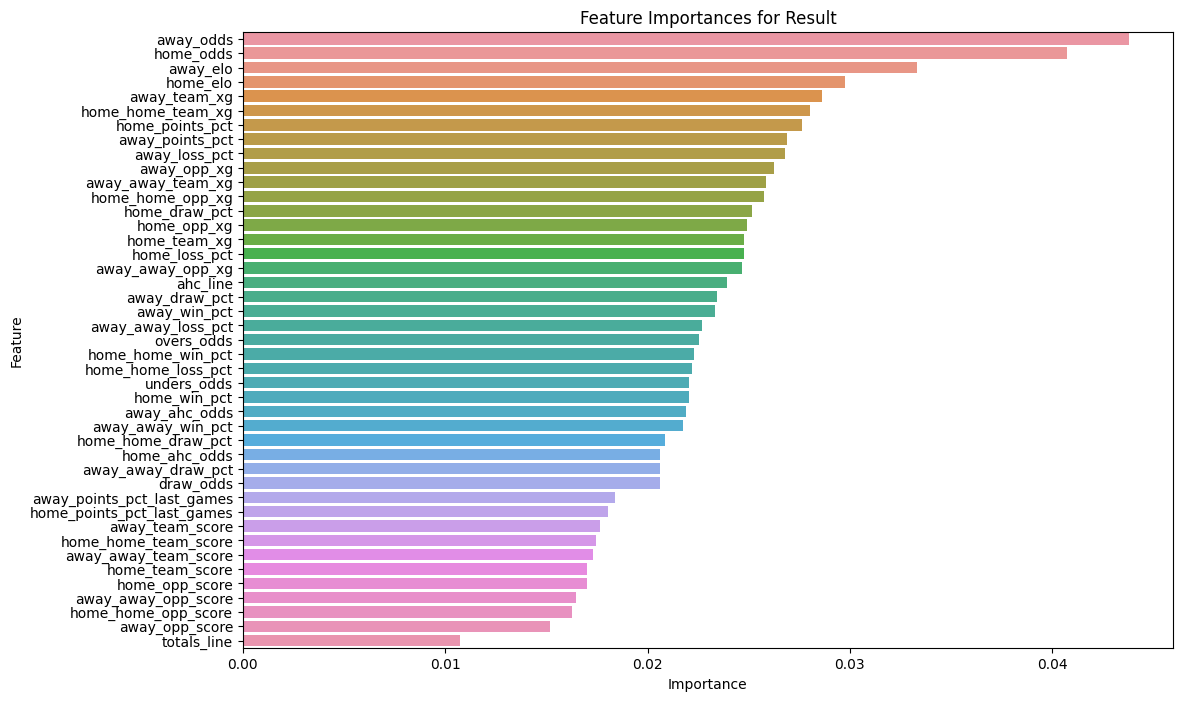

Feature Importances for Ahc_result:


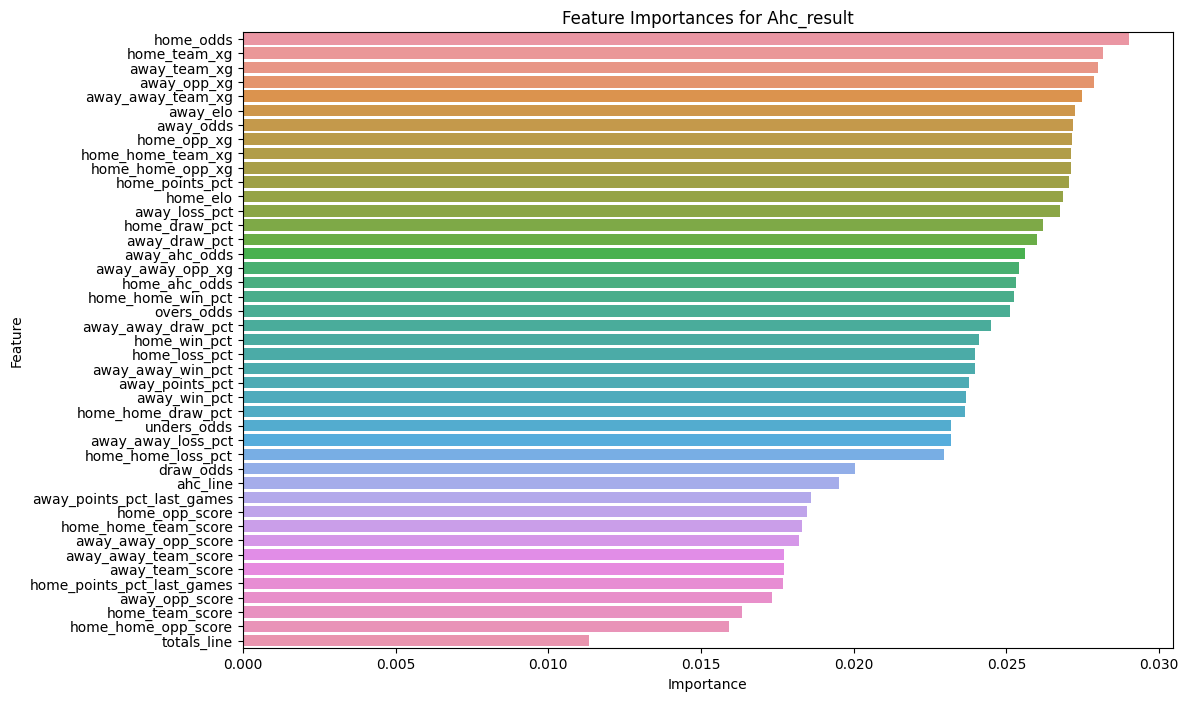

Feature Importances for Totals_result:


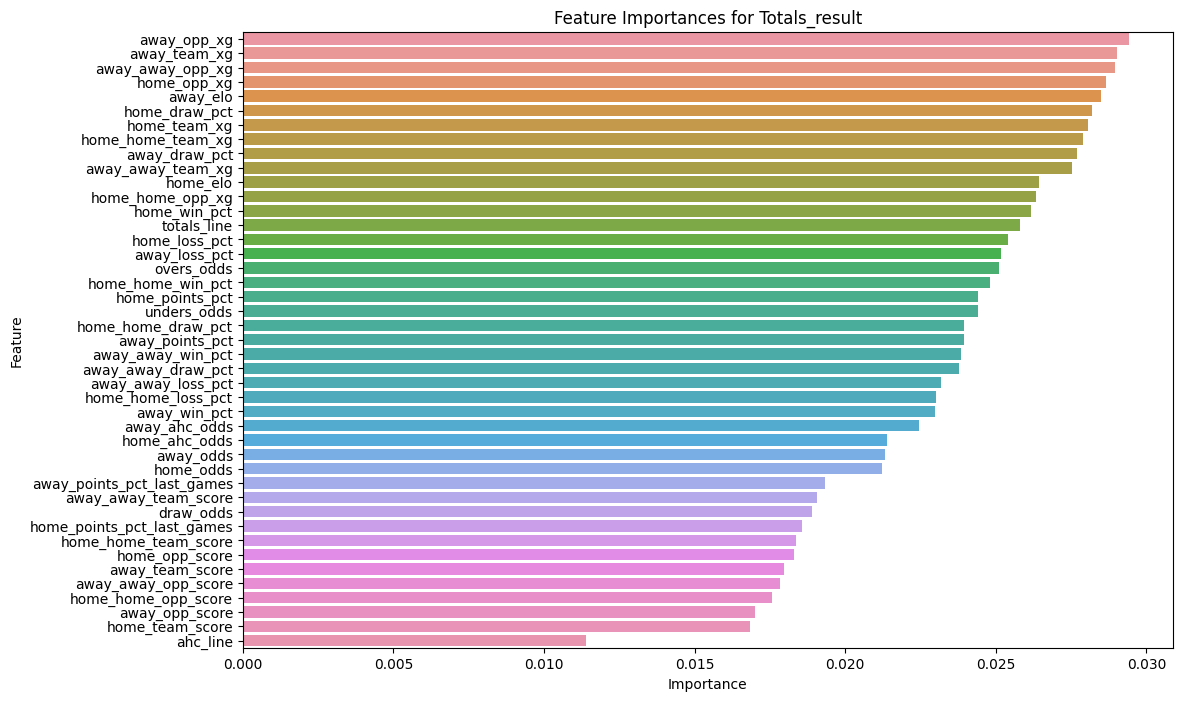

In [8]:
pf.display_random_forest_feature_importances(last_season_models, filtered_cols)

In [9]:
matches

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,proba_totals_result_U_ada_boost,proba_totals_result_P_ada_boost,pred_totals_result_mlp,proba_totals_result_O_mlp,proba_totals_result_U_mlp,proba_totals_result_P_mlp,pred_totals_result_voting_classifier,proba_totals_result_O_voting_classifier,proba_totals_result_U_voting_classifier,proba_totals_result_P_voting_classifier
0,0.633333,0.600000,0.100000,0.300000,0.633333,0.6,0.1,0.3,0.600000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.300000,0.200000,0.300000,0.500000,0.300000,0.2,0.3,0.5,0.200000,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.600000,0.500000,0.300000,0.200000,0.600000,0.5,0.3,0.2,0.600000,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.433333,0.400000,0.100000,0.500000,0.433333,0.4,0.1,0.5,0.400000,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.400000,0.400000,0.000000,0.600000,0.400000,0.4,0.0,0.6,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,0.459459,0.351351,0.324324,0.324324,0.500000,0.4,0.3,0.3,0.333333,0.388889,...,0.333107,0.336205,O,0.813635,0.044632,0.141733,U,0.402644,0.166922,0.430434
3581,0.729730,0.675676,0.162162,0.162162,0.800000,0.8,0.0,0.2,0.833333,0.055556,...,0.331410,0.334158,O,0.839533,0.033778,0.126689,O,0.469616,0.135328,0.395056
3582,0.630631,0.513514,0.351351,0.135135,0.633333,0.5,0.4,0.1,0.611111,0.333333,...,0.309391,0.344493,O,0.794969,0.147394,0.057637,U,0.379143,0.068268,0.552589
3583,0.369369,0.297297,0.216216,0.486486,0.266667,0.2,0.2,0.6,0.388889,0.166667,...,0.332517,0.335450,O,0.700404,0.222494,0.077102,U,0.335326,0.078107,0.586567


--------------------------------------------------
1x2 Classification Results


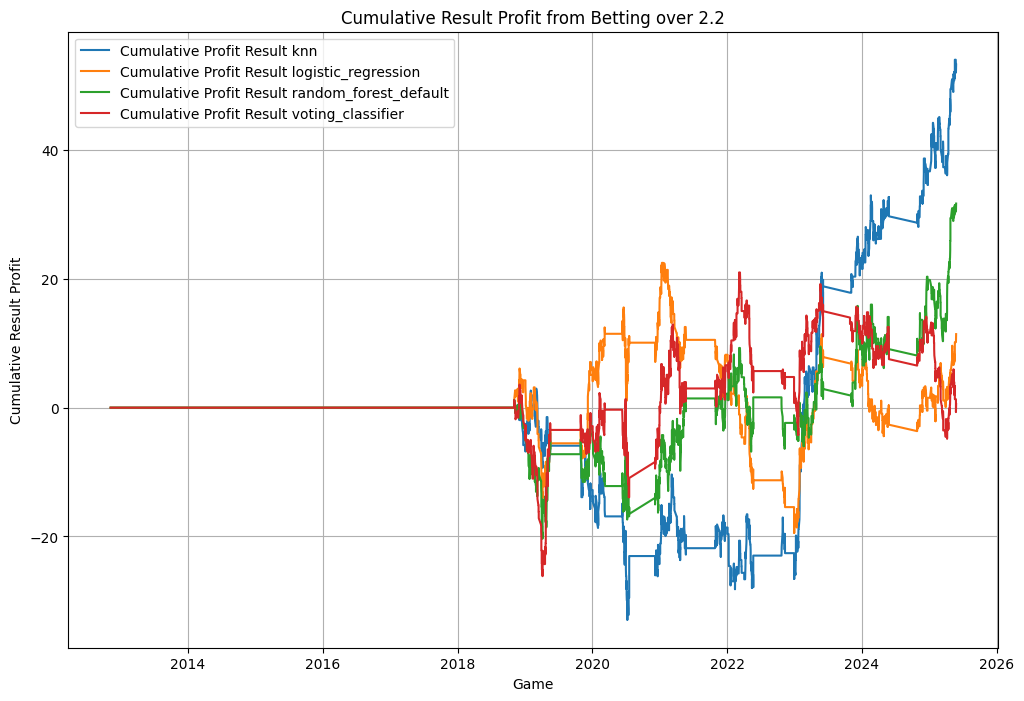

Result Elo method (-468.1/2679): -0.1747
Result Home method (-85.26/1586): -0.0538
Result method with naive_bayes          --> (   -8.6/902): -0.0095
Result method with knn                  --> (   53.3/729): 0.0731
Result method with logistic_regression  --> (  11.43/662): 0.0173
Result method with svm                  --> ( -26.11/799): -0.0327
Result method with random_forest_default --> (  31.71/749): 0.0423
Result method with random_forest        --> (  -2.09/710): -0.0029
Result method with gradient_boosting    --> ( -30.79/864): -0.0356
Result method with ada_boost            --> ( -65.43/946): -0.0692
Result method with mlp                  --> (-116.17/992): -0.1171
Result method with voting_classifier    --> (   0.57/722): 0.0008

Result Profit for knn: $53.3
Result Accuracy for knn: 0.52
Result Classification Report for knn:
              precision    recall  f1-score   support

           A       0.53      0.45      0.49       538
           D       0.36      0.06      0.11

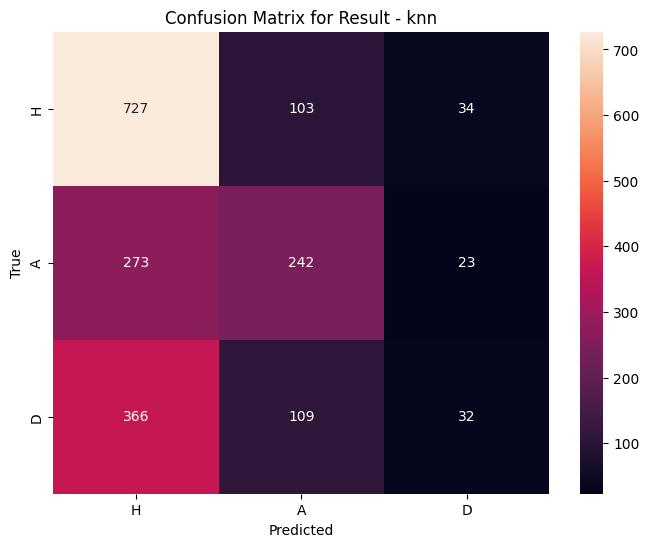

--------------------------------------------------
AHC Classification Results


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


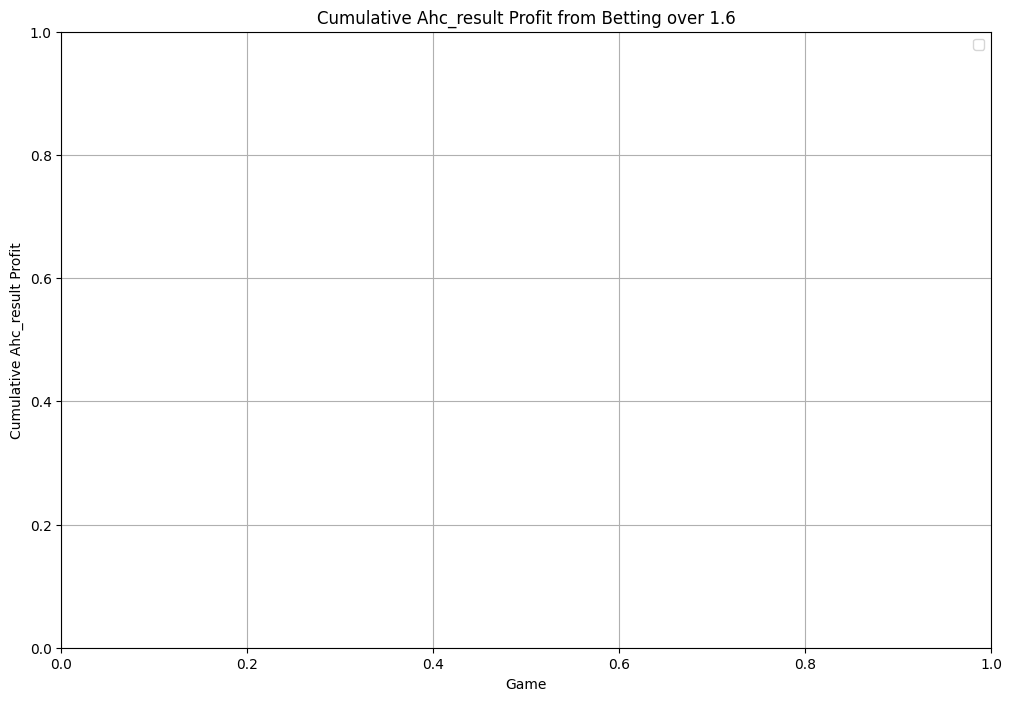

Ahc_result Elo method (-93.26/3055): -0.0305
Ahc_result Home method (-91.21/3054): -0.0299
Ahc_result method with naive_bayes          --> ( -33.53/1652): -0.0203
Ahc_result method with knn                  --> ( -33.74/1755): -0.0192
Ahc_result method with logistic_regression  --> ( -29.76/1755): -0.017
Ahc_result method with svm                  --> ( -23.52/1755): -0.0134
Ahc_result method with random_forest_default --> (-70.395/1754): -0.0401
Ahc_result method with random_forest        --> ( -86.93/1755): -0.0495
Ahc_result method with gradient_boosting    --> (-49.415/1721): -0.0287
Ahc_result method with ada_boost            --> ( -45.81/1690): -0.0271
Ahc_result method with mlp                  --> ( -59.78/1755): -0.0341
Ahc_result method with voting_classifier    --> (-79.525/1753): -0.0454

Ahc_result Profit for svm: $-23.52
Ahc_result Accuracy for svm: 0.47
Ahc_result Classification Report for svm:
              precision    recall  f1-score   support

           A       0.4

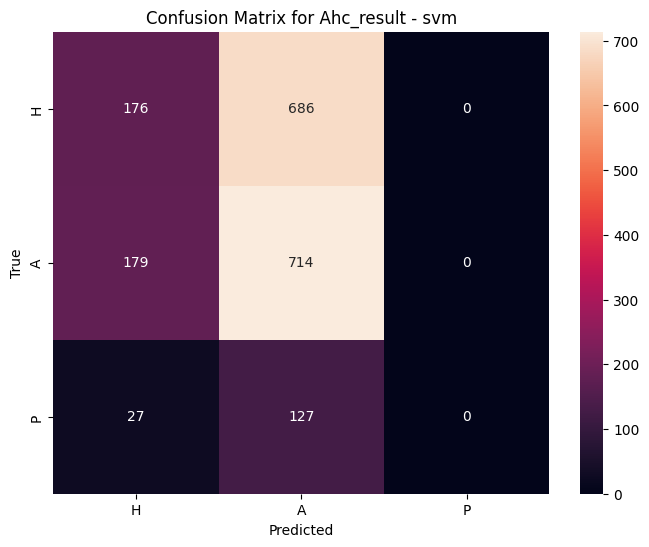

--------------------------------------------------
Totals Classification Results


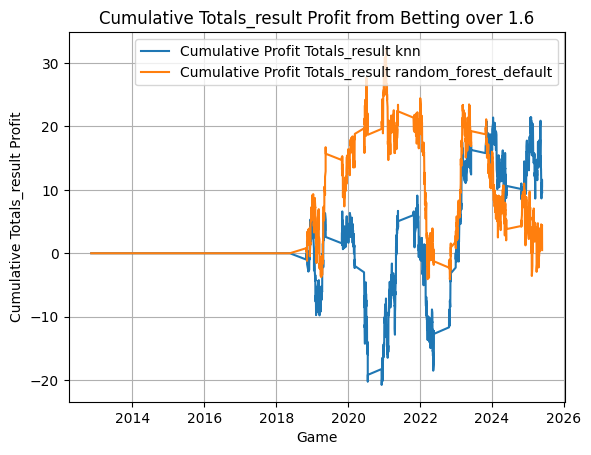

Totals_result method with naive_bayes          --> ( -16.69/1662): -0.01
Totals_result method with knn                  --> (   9.58/1793): 0.0053
Totals_result method with logistic_regression  --> (-55.935/1792): -0.0312
Totals_result method with svm                  --> ( -16.32/1793): -0.0091
Totals_result method with random_forest_default --> (    0.5/1792): 0.0003
Totals_result method with random_forest        --> (-26.675/1792): -0.0149
Totals_result method with gradient_boosting    --> ( -31.41/1748): -0.018
Totals_result method with ada_boost            --> (-12.585/1752): -0.0072
Totals_result method with mlp                  --> (-18.085/1791): -0.0101
Totals_result method with voting_classifier    --> (-13.125/1788): -0.0073

Totals_result Profit for knn: $9.58
Totals_result Accuracy for knn: 0.49
Totals_result Classification Report for knn:
              precision    recall  f1-score   support

           O       0.46      0.40      0.43       843
           P       0.00   

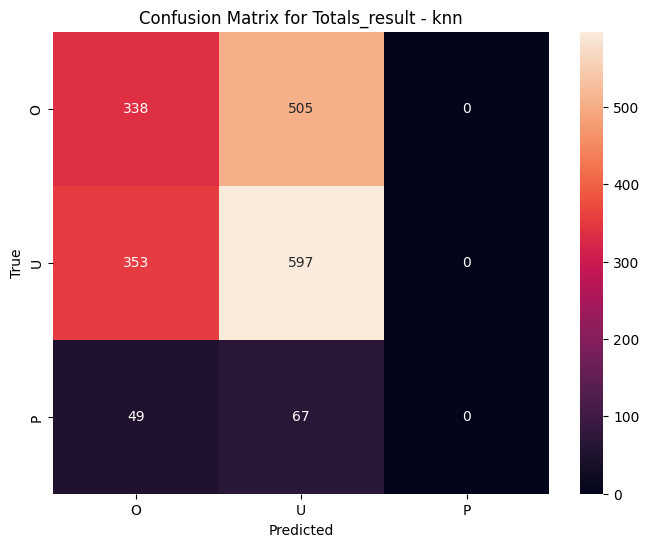

In [13]:
min_odds_1x2 = markets["result"][1]
min_odds_ahc = markets["ahc_result"][1]
min_odds_totals = markets["totals_result"][1]

best_1x2_model, best_ahc_model, best_totals_model = pf.get_classification_simulation_results(
    matches,
    start_season,
    plot_threshold,
    bankroll,
    strategy,
    default_value,
    default_bankroll_pct,
    min_odds_1x2,
    min_odds_ahc,
    min_odds_totals,
)

In [14]:
matches_filtered = matches[["date",  "season", "home_team", "away_team", "home_score", "away_score", "result", "home_odds", "draw_odds", "away_odds", f"PredictedRes_{best_model_name}", f'ProfitML_{best_model_name}', f'CumulativeProfitML_{best_model_name}']]
matches_filtered = matches_filtered[matches_filtered["season"] == 2024]
matches_filtered.tail(5)

# matches_filtered.to_csv("analysis_predictor.csv")

NameError: name 'best_model_name' is not defined

In [ ]:
my_pipeline = trained_models[best_model_name]["pipeline"]
my_pipeline

data = {
    "pipeline": my_pipeline,
    "best_model_name": best_model_name,
    "min_games_played": min_games_played,
    "min_games_played_at": min_games_played_at,
    "min_odds": min_odds,
    "filtered_cols": filtered_cols,
    "strategy": strategy,
    "default_value": default_value,
    "default_bankroll_pct": default_bankroll_pct
}

# Save the pipeline
if save_pipeline:
    path = f"../dist/betting"
    
    save_file(path, data, league)

: 